In [1]:
USER = 'laphisboy'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

MODEL_SAVE_PATH = '/content/gdrive/My Drive/Colab Notebooks/dacon_12/model_save/'

Mounted at /content/gdrive


In [9]:
pip install git+https://github.com/laphisboy/pytorch-image-models.git

  Cloning https://github.com/laphisboy/pytorch-image-models.git to /tmp/pip-req-build-q5wv_q70
  Running command git clone -q https://github.com/laphisboy/pytorch-image-models.git /tmp/pip-req-build-q5wv_q70
  Created wheel for timm: filename=timm-0.4.2-cp36-none-any.whl size=266018 sha256=ff9cff7e96dc69c4342b3bec86da3b4d05fed4ce7b291d060e864222a032cbed
  Stored in directory: /tmp/pip-ephem-wheel-cache-qr4t1maq/wheels/61/8c/86/d8837b09a6d24d66496d9612389e2b244f129d1083286ab198
Successfully built timm


In [15]:
from google.colab import output

DATA_ZIP_PATH = '/content/gdrive/My Drive/Colab Notebooks/data/data_2/'

# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/gdrive/My Drive/Colab Notebooks/data/data_2_2.zip" "data_2_2.zip"
# data_2.zip을 현재 디렉터리에 압축해제
!unzip "data_2_2.zip"

Archive:  data_2_2.zip
  inflating: dirty_mnist_2nd.zip     
  inflating: dirty_mnist_2nd_answer.csv  
  inflating: mnist_data.zip          
  inflating: sample_submission.csv   
  inflating: test_dirty_mnist_2nd.zip  


In [16]:
# 현재 디렉터리에 dirty_mnist라는 폴더 생성
#!mkdir "./dirty_mnist_2nd"
#dirty_mnist.zip라는 zip파일을 dirty_mnist라는 폴더에 압축 풀기
#!unzip "dirty_mnist_2nd.zip" -d "./dirty_mnist_2nd/"
# 현재 디렉터리에 test_dirty_mnist라는 폴더 생성
!mkdir "./test_dirty_mnist_2nd"
#test_dirty_mnist.zip라는 zip파일을 test_dirty_mnist라는 폴더에 압축 풀기
!unzip "test_dirty_mnist_2nd.zip" -d "./test_dirty_mnist_2nd/"
# 출력 결과 지우기
output.clear()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import imutils
import zipfile
import os
from PIL import Image
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from google.colab import output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#dirty_mnist_answer = pd.read_csv(DIRTY_MNIST_ANSWER_PATH)

In [ ]:
dirty_mnist_answer = pd.read_csv('dirty_mnist_2nd_answer.csv')
# dirty_mnist라는 디렉터리 속에 들어있는 파일들의 이름을 
# namelist라는 변수에 저장
#namelist = os.listdir('./dirty_mnist/')

In [ ]:
dirty_mnist_answer

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,1,1,0,1,1,0,1,0,0,1,1,1
1,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,1
2,2,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0
3,3,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0
4,4,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,0,1,1,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0
49996,49996,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,1
49997,49997,0,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0
49998,49998,0,1,1,1,0,0,1,1,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0


In [ ]:


#namelist = os.listdir(DIRTY_MNIST_PATH)

In [ ]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [22]:
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self,
                 dir_path,
                 meta_df,
                 transforms,
                 augmentations=None):
        self.dir_path = dir_path
        self.meta_df = meta_df

        self.transforms = transforms
        self.augmentations = augmentations

    def __len__(self):
        return len(self.meta_df)

    def __getitem__(self,index):

        #image = cv2.imread(self.dir_path +\
        #                   str(self.meta_df.iloc[index,0]).zfill(5) + '.png',
        #                   cv2.IMREAD_COLOR)
        
        image = Image.open(
            self.dir_path+str(self.meta_df.iloc[index,0]).zfill(5) + '.png',
        )

        image = self.transforms(image)

        # image = (image/255).astype('float')[..., np.newaxis]
        # might need to check on why this is necessary

        label = self.meta_df.iloc[index, 1:].values.astype('float')

        return image, torch.FloatTensor(label)

torch.Size([3, 256, 256])


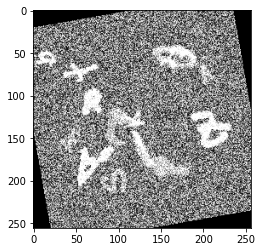

In [ ]:
train_dataset = DatasetMNIST('dirty_mnist_2nd/', dirty_mnist_answer, T.ToTensor())

train_data_loader = DataLoader(
        train_dataset,
        batch_size = 1,
        shuffle = True,
        num_workers=3
    )

image, label=next(iter(train_data_loader))
image = TF.rotate(image, 0)
print(np.squeeze(image, axis=0).shape)
imshow(np.squeeze(image))

In [7]:
# nn.Module을 상속 받아 MultiLabelResnet를 정의
class MultiLabelAntiEfficientNet(nn.Module):
    def __init__(self):
        super(MultiLabelAntiEfficientNet, self).__init__()
        #self.conv2d = nn.Conv2d(1, 3, 3, stride=1)
        self.model = timm.create_model('tf_efficientnet_b4_ns', pretrained=False)
        self.model.conv_stem = nn.Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 10)

    def forward(self, x):
        # resnet의 입력은 [3, N, N]으로
        # 3개의 채널을 갖기 때문에
        # resnet 입력 전에 conv2d를 한 층 추가
        #x = F.relu(self.conv2d(x))

        # resnet18을 추가
        # = F.relu(self.model(x))

        # 마지막 출력에 nn.Linear를 추가
        # multilabel을 예측해야 하기 때문에
        # softmax가 아닌 sigmoid를 적용
        x = self.model(x)
        return x
# 모델 선언


In [11]:
MODEL = 'antiefficient'
AFTERTRAINED = 'afterEMNISTletter'
path = MODEL_SAVE_PATH
model = torch.load(f'{path}{USER}_{MODEL}_{AFTERTRAINED}_1.pth')

In [12]:
model.to(device)

MultiLabelAntiEfficientNet(
  (model): EfficientNet(
    (conv_stem): Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
from sklearn.model_selection import KFold

best_models = []

train_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, train_transform)
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, eval_transform)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(20):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        lr_scheduler.step()

        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            MODEL = 'resnet18'
            path = MODEL_SAVE_PATH
            torch.save(best_model, f'{path}{USER}_{fold_index}_{MODEL}.pth')
    best_models.append(best_model)


[fold: 1]


Valid Epoch 19: 100%|██████████| 313/313 [00:15<00:00, 20.34batch/s, valid_acc=0.617, valid_loss=1.13]

[fold: 2]


In [ ]:
train_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, train_transform)
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, eval_transform)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(20):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                images = TF.rotate(images, angle=90)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        lr_scheduler.step()

        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            MODEL = 'resnet18'
            path = MODEL_SAVE_PATH
            torch.save(best_model, f'{path}{USER}_{fold_index}_{MODEL}.pth')
    best_models.append(best_model)

[fold: 1]


Valid Epoch 19: 100%|██████████| 313/313 [00:14<00:00, 21.32batch/s, valid_acc=0.606, valid_loss=0.87]

[fold: 2]


In [ ]:
train_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, train_transform)
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, eval_transform)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(20):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                images = TF.rotate(images, angle=180)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        lr_scheduler.step()

        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            MODEL = 'resnet18'
            path = MODEL_SAVE_PATH
            torch.save(best_model, f'{path}{USER}_{fold_index}_{MODEL}.pth')
    best_models.append(best_model)

[fold: 1]


Valid Epoch 19: 100%|██████████| 313/313 [00:14<00:00, 22.29batch/s, valid_acc=0.609, valid_loss=0.808]

[fold: 2]


In [ ]:
train_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, train_transform)
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, eval_transform)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(20):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                images = TF.rotate(images, angle=270)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        lr_scheduler.step()

        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            MODEL = 'resnet18'
            path = MODEL_SAVE_PATH
            torch.save(best_model, f'{path}{USER}_{fold_index}_{MODEL}.pth')
    best_models.append(best_model)

[fold: 1]


Valid Epoch 19: 100%|██████████| 313/313 [00:14<00:00, 21.50batch/s, valid_acc=0.614, valid_loss=1.04]

[fold: 2]


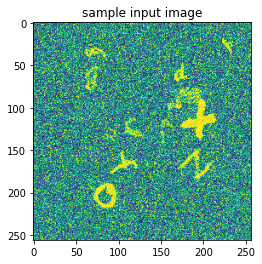

예측값 :  Index(['b', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'n', 'o', 'q', 'u', 'v', 'x',
       'y'],
      dtype='object')
예측값 :  Index(['b', 'd', 'f', 'h', 'j', 'o', 'q', 'r', 't', 'w', 'x', 'z'], dtype='object')


In [ ]:
# check image and prediction
sample_images = images.cpu().detach().numpy()
sample_prob = probs
sample_labels = labels

idx = 1
plt.imshow(sample_images[idx][0])
plt.title("sample input image")
plt.show()

print('예측값 : ', dirty_mnist_answer.columns[1:][sample_prob[idx] > 0.5])
print('예측값 : ', dirty_mnist_answer.columns[1:][sample_labels[idx] > 0.5])

In [23]:
# try ensemble and submit
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
sample_submission = pd.read_csv("sample_submission.csv")
test_dataset = DatasetMNIST("test_dirty_mnist_2nd/", sample_submission, eval_transform)

batch_size = 128

test_data_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 3,
    drop_last = False
)

In [24]:
predictions_list = []

prediction_df = pd.read_csv("sample_submission.csv")



prediction_array = np.zeros([prediction_df.shape[0],
                                prediction_df.shape[1]-1])

for idx, (images, _) in enumerate(test_data_loader):
    with torch.no_grad():
        model.eval()
        images = images.to(device)
        probs = model(images)
        probs = probs.cpu().detach().numpy()
        preds = (probs > 0.5)

        batch_index = batch_size * idx
        prediction_array[batch_index: batch_index + images.shape[0], :] = preds.astype(int)

In [29]:
predictions_mean = (prediction_array > 0.5) * 1 # * 1 이 필요하나
print(predictions_mean)

[[1 0 1 ... 1 0 1]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [1 1 0 ... 1 1 1]]


In [30]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.iloc[:, 1:] = predictions_mean
sample_submission.to_csv("submit.csv", index=False)
sample_submission

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,50000,1,0,1,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,0,1
1,50001,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0
2,50002,0,0,1,1,1,0,1,1,1,0,1,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1
3,50003,1,1,0,0,0,1,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
4,50004,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,54995,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0
4996,54996,1,1,1,0,1,0,0,0,1,1,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,1
4997,54997,1,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,0,1,1,1,0,0,1
4998,54998,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1


In [ ]:
# 0.6315384615	

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Feb  5 14:04:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    55W / 300W |   6573MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!
